In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tfds.__version__

'3.1.0'

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

## Создание модели CNN

In [11]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [12]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [13]:
BATCH_SIZE = 128
NUM_EPOCHS = 1
INP_SIZE = 100


def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return label, tf.image.resize(img, (INP_SIZE, INP_SIZE))

In [15]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [16]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [17]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 90.51570129394531
CPU times: user 12min 19s, sys: 1min 10s, total: 13min 30s
Wall time: 3min 58s


## Получение эмбеддингов для тестовой выборки

In [26]:
train_ds

<BatchDataset shapes: ((None,), (None, 100, 100, 3)), types: (tf.string, tf.float32)>

In [27]:
test_ds = test_ds.map(prepare)
# test_ds = test_ds.batch(BATCH_SIZE)

In [72]:
test_y = [tfds.as_numpy(y).decode('utf-8') for y, x in test_ds]
test_x = [x for y, x in test_ds]

In [67]:
test_embs = []
for iteration, (labels, images) in enumerate(test_ds):
    
    # Forward
#     test_embs = model(images[None, ...])
    test_embs.append(np.ndarray.tolist(model(images[None, ...]).numpy()[-1, ...]))

## Функция для визуализации эмбеддингов

In [80]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(len(labels_for_viz)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [83]:
labels_for_viz[:,0]

TypeError: list indices must be integers or slices, not tuple

In [75]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_y[:1000]

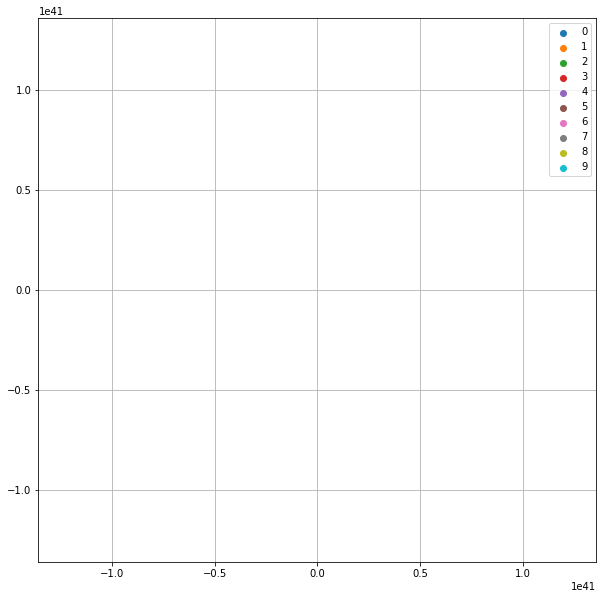

In [81]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))